In [1]:
from IPython.display import HTML

In [2]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [3]:
import pandas as pd
import spacy
import matplotlib.pyplot as plt
import numpy as np
import en_core_web_md
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
def read_data(file_name, encoding):
    return pd.read_csv(file_name, encoding=encoding)

In [5]:
#Load data
data = read_data(file_name='companies.csv', encoding='ISO-8859-1')
nlp = en_core_web_md.load()

## Data cleaning, tokenization and transformation

We'll use [Spacy](https://spacy.io/) a core library for NLP.

First, we observe the description column and search for common patterns and things that are irrelevant for our core task - clustering. The first visible thing is that descriptions contain the company names and we can assume, that the last sentence is the information on headquarter location and foundation date. For example *"A. O. Smith Corporation is headquartered in Milwaukee, Wisconsin."*,  *"Accenture plc was founded in 1989 and is based in Dublin, Ireland."*
Another noticeable thing is that some sentences contain information about company ticker symbol; they are also irrelevant for field description.
So, we will search for sentences, that have words *founded, based, headquarter, headquartered, incorporated, trades, traded* and remove the whole sentence. 

In [61]:
remove_words = ['founded', 'based', 'headquarter', 'headquartered', 'incorporated','trades', 'traded']

In [7]:
def check_sentences(list_of_sentences, words_to_search): 
    for sent in list_of_sentences: 
        tokens = [token.text for token in nlp(sent)]
        result = any(elem in tokens for elem in words_to_search)
        if result:
            list_of_sentences.remove(sent)
    return list_of_sentences

Next, we will extract only independent parts of speech, to create the representation of the description, but without the company name, stopwords, named entities, conjunctions, ect.. We will extract only adjectives, adverbs, nouns, and verbs. 

As our core task is clustering, we want to create vector representation from given descriptions. There are several possible ways to do that. One way is to create TF-IDF vector representation - sparse representation, with dimentionality of the dictionary (num of unique words in all given description, that are independent parts of speech and length of tokens is more than 2 letters). Another way is to create a mean vector representation of words. Spacy model already has vector representations of common words (let's use function *get_token_vectors* to extract word tokens and list, that have vector representation on tokens). 

In [22]:
def get_token_vectors(text): 
    tags = ['ADJ', 'ADV', 'NOUN', 'VERB']
    text = nlp(text)
    ftokens = list(filter(lambda token: token.pos_ in tags and len(token.text)>2
                          and not token.is_stop and token.has_vector, text))
    token_vec = list(map(lambda v: v.vector , ftokens))
    token_text = list(map(lambda v: v.lower_, ftokens))
    return token_text, token_vec

def split_into_sentences(text, nlp):
    text = nlp(text)
    return [sent.string.strip() for sent in text.sents]

def custom_vectorizer(discr):
    """
    Parse description into meaningful tokens
    :param discr: company description
    :return: list of tokens, list of vectors 
    """
    tokens, vectors = [], []
    sentences = split_into_sentences(discr, nlp)
    sentences = check_sentences(sentences, remove_words)
    for sent in sentences:
        text, vec = get_token_vectors(sent)
        tokens.extend(text)
        vectors.extend(vec)
    return tokens, vectors

def custom_tokenizer(discr):
    """
    Parse description into meaningful tokens
    :param discr: company description
    :return: list of tokens 
    """
    tokens = []
    sentences = split_into_sentences(discr, nlp)
    sentences = check_sentences(sentences, remove_words)
    for sent in sentences:
        text, _ = get_token_vectors(sent)
        tokens.extend(text)
    return tokens

def calc_mean_vect(list_of_token_vec):
    return sum(list_of_token_vec)/len(list_of_token_vec)

In [9]:
def create_tf_idf_representation(descr):
    tfidf_vector = TfidfVectorizer(tokenizer=custom_tokenizer)
    X = tfidf_vector.fit_transform(descr)
    return X

In [10]:
TFIDF_repr = create_tf_idf_representation(list(data.description))

In [60]:
print('TF-IDF representation shape')
TFIDF_repr.shape

TF-IDF representation shape


(494, 7701)

In [58]:
def get_len_tokens(single_desc): 
    tokens = custom_tokenizer(single_desc)
    return len(tokens)

def visualize_token_size(description): 
    tokens_size = [get_len_tokens(desc) for desc in description]
    index = np.arange(len(tokens_size))
    plt.figure(figsize=(15, 9))
    plt.bar(index, tokens_size)
    plt.xlabel('Index', fontsize=10)
    plt.ylabel('Number of extracted tokens', fontsize=10)
    plt.title('Number of words representing each company')
    plt.show()

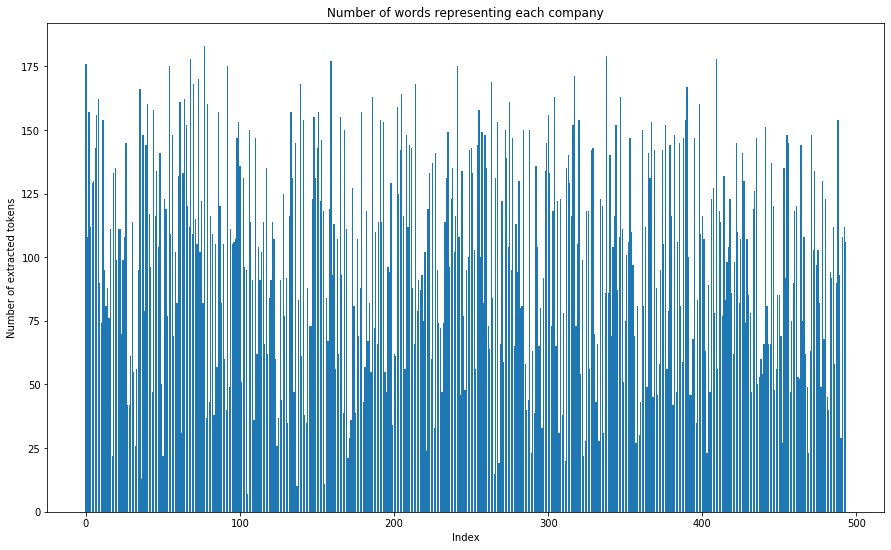

In [59]:
visualize_token_size(list(data.description))

As we can see, the TFIDF vector is of size **7701**, but this is a very sparse representation. As we can see on visualization, most of the descriptions don't have more than **175** words (this might not be a unique word). Such representation as TF-IDF has bigger dictionary size that the number of data points we have, so we need to transform TD-IDF matrix to a less sparse representation of smaller dimensionality. 
The first alternative approach to try is Mean Word2Vec representation. The Spacy library already has a built-in vector representation of meaningful words. Every word is represented as a 300-dimensional vector (which is already of size smaller than dataset size). The mean of all extracted words is document representation. A critical thing about word2vec representation is that metrics in this space is a cosine similarity and that this representation knows about the relationship between words (so that synonyms are close in space). We can expect such representation to put similar descriptions close enough in space.

In [30]:
def get_w2v_representation(descr):
    X=[]
    for doc in descr:
        tok, vectors = custom_vectorizer(doc)
        feature_vec = calc_mean_vect(vectors)
        X.append(feature_vec)
    return np.array(X)

In [31]:
vect_representation = get_w2v_representation(list(data.description))

The other things to try that might improve representation is extracting key phrases instead of words by applying [rake_nltk ](https://pypi.org/project/rake-nltk/). 

## Clustering

As our metric of representation set is cosine similarity, we have to use unsupervised clustering method, that supports cosine similarity.

One of such methods is - **Hierarchical Clustering**.  This method treats each data point as one cluster at the beginning and then trying to update them into a given number of clusters. 
In our case, we don't know the expected number of clusters, the suggested way to understand the number of clusters in data - building the dendrogram.

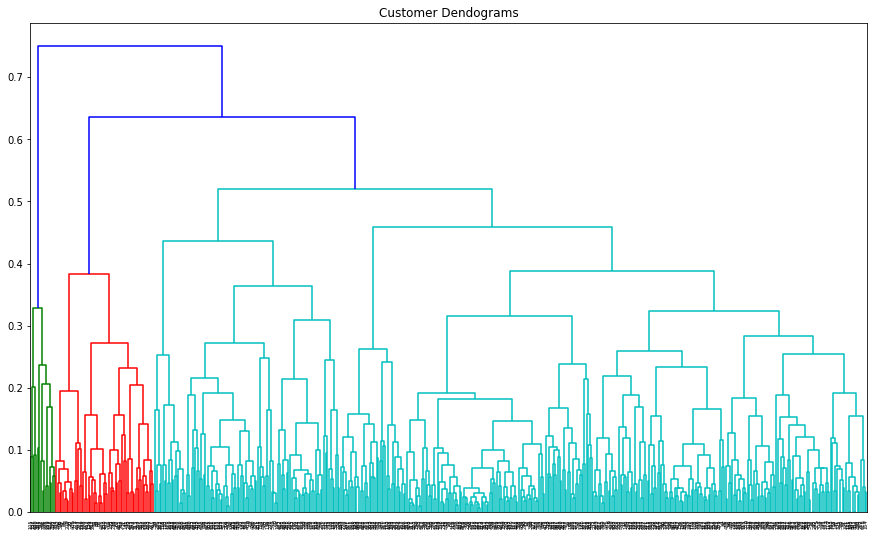

In [40]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(15, 9))
plt.title("Description Dendogram")
dend = shc.dendrogram(shc.linkage(vect_representation, metric='cosine', method='complete'))

This dendrogram shows that expected number of clusters is between 10 and 12. 

In [65]:
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics

In [42]:
def clusterize_data(data, num_clusters):
    return AgglomerativeClustering(n_clusters=num_clusters,
                                   affinity='cosine',
                                   linkage='complete').fit(data)

In [82]:
score = []
for k in range(9, 13, 1):
    clustering = clusterize_data(vect_representation, k)
    results = clustering.labels_
    value = metrics.silhouette_score(vect_representation, results, metric='cosine')
    score.append((k, value))

In [83]:
print(score)

[(9, 0.22363767), (10, 0.22377396), (11, 0.25707957), (12, 0.25964725)]


As a metrics to evaluate better clusterization we can use *Silhouette Coefficient*. We will try different number of clusters and we can choose the clusterization with higest score. 

In [46]:
clustering = clusterize_data(vect_representation, 11)
results = clustering.labels_

Here when we move from 10 to 11, we can see result we would look for using the *Elbow method*. The sudden jump in metrics score. Any increase in number of clusters will increase the score. Here we can stop on **11 clusters**. 

In [55]:
data['Clustering'] = list(results)

In [92]:
def save_result(data): 
    cut = data.copy()
    cut.drop(['Name', 'description'], axis=1, inplace=True)
    cut.to_csv(path_to_save, index=False)

In [93]:
save_result(data, 'Clustering_results.csv')

## Validation

Another, a bit cheating way to validate the correctness of results is actually searching for company fields of S&P 500 companies. So it was easy to google cvs file with tickers and company fields at [datahub.io](https://datahub.io/core/s-and-p-500-companies). We will read that data frame and megre them based on Symbol

In [94]:
def merge_tables(data, new_data): 
    new_data.drop(['Name'], axis=1, inplace=True)
    result = pd.merge(data, new_data, on=['Symbol', 'Symbol'], how='inner')
    return result

In [95]:
additional_data = read_data('constituents_csv.csv', encoding='utf-8')
merged = merge_tables(data, additional_data)

In [96]:
merged.head(20)

,Symbol,Name,description,Clustering,Sector
0,MMM,3M Company,3M Company operates as a diversified technolog...,8,Industrials
1,AOS,A.O. Smith Corp,A. O. Smith Corporation manufactures and marke...,10,Industrials
2,ABT,Abbott Laboratories,"Abbott Laboratories discovers, develops, manuf...",7,Health Care
3,ABBV,AbbVie Inc.,"AbbVie Inc. discovers, develops, manufactures,...",7,Health Care
4,ACN,Accenture plc,"Accenture plc provides consulting, technology,...",2,Information Technology
5,ATVI,Activision Blizzard,"Activision Blizzard, Inc. develops and distrib...",2,Information Technology
6,AYI,Acuity Brands Inc,"Acuity Brands, Inc. provides lighting and buil...",10,Industrials
7,ADBE,Adobe Systems Inc,Adobe Inc. operates as a diversified software ...,2,Information Technology
8,AAP,Advance Auto Parts,"Advance Auto Parts, Inc. provides automotive r...",8,Consumer Discretionary
9,AMD,Advanced Micro Devices Inc,"Advanced Micro Devices, Inc. operates as a sem...",2,Information Technology


# Conclusions

The number of clusters predicted by *Elbow method with Silhouette Coefficient as metrics* is the same as real S&P 500 fields. 

The possible improvement can be done by appling rake_nltk for extracting key-phrases instead of words, also more metrix on tokens, such as TF itself, so we could build representation based on key words. Other thing to try might be appling pretrained Doc2Vec insted of mean word2vec.  
Other thing to try might be other clustering techiques, but we should be realy careful with a metrics in feature space. 